# Machine Energy Analysis Pipeline

This notebook demonstrates the use of a machine energy analysis pipeline, including data visualization before and after outlier removal.

In [2]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


from machine_analyzer.machine_data_loader import MachineDataLoader
from machine_analyzer.state_detector import StateDetector
from machine_analyzer.cycle_segmenter import CycleSegmenter
from machine_analyzer.quality_analyzer import QualityAnalyzer
from machine_analyzer.report_generator import ReportGenerator


plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Visualization Function

The `visualize_outlier_removal` function is used to compare the original dataset and the processed dataset after outlier removal. It provides a visual representation of the data before and after processing, helping to understand the impact of outlier removal on the dataset.

In [3]:

def visualize_outlier_removal(original_data, processed_data, threshold: str = None, energy_column='value',
                              title_suffix='', save_plot=False, filename='outlier_comparison.png'):
    """
    Visualize the effect of outlier removal by comparing original and processed data.

    Args:
        original_data (pd.DataFrame): The original dataset before outlier removal.
        processed_data (pd.DataFrame): The dataset after outlier removal.
        threshold (str, optional): If provided, use this column from processed_data instead of energy_column.
        energy_column (str): The name of the column to visualize.
        title_suffix (str): Extra text to add to the main title.
        save_plot (bool): Whether to save the plot as an image file.
        filename (str): The name of the file to save the plot.

    Returns:
        None
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 9))
    fig.suptitle(f'Comparison of Data Before/After Outlier Removal {title_suffix}',
                 fontsize=16, fontweight='bold')
    
    if threshold is not None:
        original_col = threshold
        original_data = processed_data
    else:
        original_col = energy_column

    # Original time series
    axes[0, 0].plot(original_data.index, original_data[original_col],
                    color='blue', alpha=0.7, linewidth=1, label='Original Data')
    axes[0, 0].set_title('Original Data - Time Series')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel(f'{original_col}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Processed time series
    axes[0, 1].plot(processed_data.index, processed_data[energy_column],
                    color='green', alpha=0.7, linewidth=1, label='Processed Data')
    axes[0, 1].set_title('Processed Data - Time Series')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel(f'{energy_column}')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    if threshold is None : 
        # Histogram of original data
        axes[1, 0].hist(original_data[energy_column], bins=50, alpha=0.7,
                        color='blue', edgecolor='black', label='Original Data')
        axes[1, 0].set_title('Distribution of Original Data')
        axes[1, 0].set_xlabel(f'{energy_column}')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Histogram of processed data
        axes[1, 1].hist(processed_data[energy_column], bins=50, alpha=0.7,
                        color='green', edgecolor='black', label='Processed Data')
        axes[1, 1].set_title('Distribution of Processed Data')
        axes[1, 1].set_xlabel(f'{energy_column}')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_plot:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved: {filename}")

    plt.show()


# Load and Resample Data

The data is loaded using the `MachineDataLoader` class and resampled to a frequency of 1 second. This step ensures uniform time intervals in the dataset, which is essential for accurate analysis and visualization.

In [4]:
loader = MachineDataLoader()
loader.load_data(data_path="../data/Datadump.txt",timestamp_column="timestamp",format="json")
resampled = loader.preprocess_data(loader.dataframe,frequency="1s",energy_column="value")

# Detect States

This section focuses on identifying different operational states of the machine, such as "off", "on", "standby", and "production". These states are determined based on energy consumption patterns and thresholds. The identified states help in analyzing machine behavior and segmenting production cycles effectively.

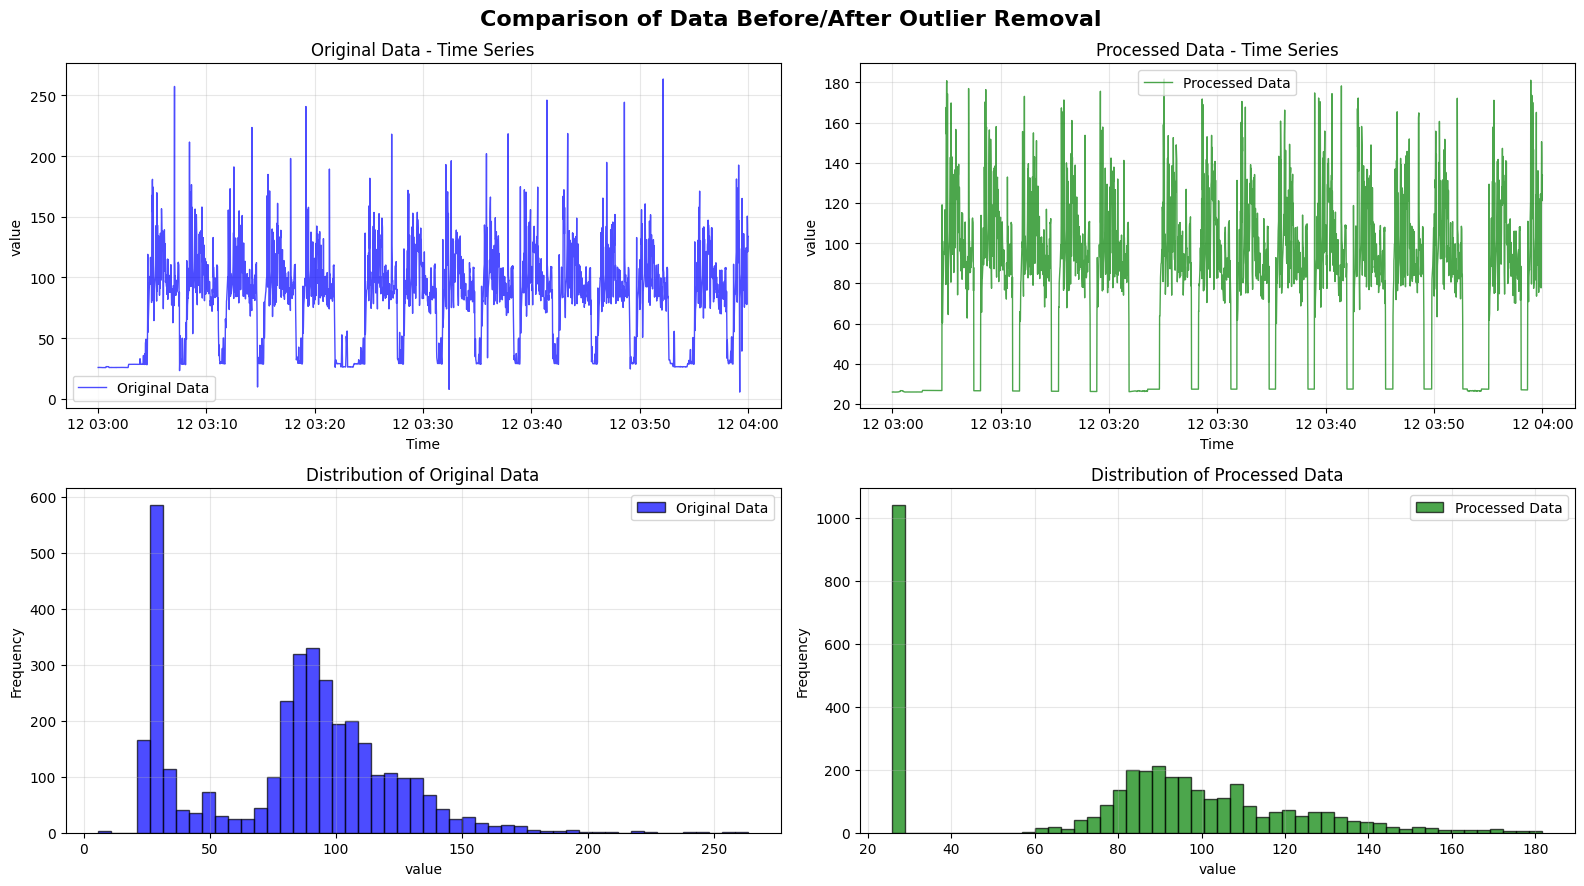

In [5]:
detector = StateDetector(resampled,"value")

detector.preprocess_states(window_size="5s",production_threshold=60,iqr_coefficients=(3,3,1.5,3),keep_threshold_column=True)

processed = detector.get_processed_data()
date_mask = (processed.index >= datetime(2025,5,12,3)) & (processed.index <= datetime(2025,5,12,4))
state_masks = detector.get_state_masks()

visualize_outlier_removal(resampled[date_mask],processed[date_mask],energy_column="value")

# Cycle Segmenter

The `CycleSegmenter` class is responsible for identifying and segmenting production cycles from the processed machine data. It uses state masks and energy consumption patterns to define the start and end of each cycle. The segmented cycles are then analyzed for their duration, energy consumption, and variation, providing insights into the machine's operational efficiency and performance.

In [39]:
segmenter = CycleSegmenter(processed,state_masks,"value")
segmenter.segment_cycles(min_duration="5s",max_duration=f'{30*60}s') # in secondes
production_cycles = segmenter.get_cycles()
cycles_stat = segmenter.get_cycle_statistics()

print('='*30)
print("cycles statistics : ")
print('='*30)
for key in cycles_stat:
    if key == "total_cycles":
        print(f'{key} : {cycles_stat[key]}')
    else:
        print(f"{key} :")
        for value in cycles_stat[key]:
            print(f"    - {value} : {float(cycles_stat[key][value])}")

cycles statistics : 
total_cycles : 79
duration_stats :
    - mean : 172.1772151898734
    - std : 17.09819702810566
    - min : 27.0
    - max : 180.0
    - median : 174.0
energy_stats :
    - mean : 17274.51338185726
    - std : 1715.1050276207034
    - mean_peak : 171.56773189345992
    - std_peak : 7.449722303992181
    - total_energy : 1364686.5571667235
variation_stats :
    - mean : 0.21542678407959415
    - std : 0.01301339251887377
    - min : 0.18823984077991313
    - max : 0.2628140619192614
    - median : 0.21474484580733486


# Analyze Cycle Quality

This section evaluates the quality of production cycles. It identifies anomalies, calculates quality scores, and categorizes cycles into grades (e.g., A, B, D). Anomalous cycles are flagged for further investigation.

In [46]:
analyser = QualityAnalyzer(cycles_stat,production_cycles)

threshold = {"variation":1,"duration":1,"energy":1}
# mean standard comparasion  (value - mean) >? threshold*std
analyser.analyze_quality(threshold_factor=threshold)

quality_metrics = analyser.get_quality_metrics()
quality_summary = analyser.get_quality_summary()
anomaly = analyser.get_anomalous_units()
print('='*30)
print("quality summary : ")
print('='*30)
for key in quality_summary:
    print(f'    - {key} : {quality_summary[key]}')

quality summary : 
    - total_cycles : 79
    - anomalous_cycles : 12
    - average_quality_score : 0.9451476793248947
    - quality_grade_distribution : {'A': 67, 'B': 11, 'D': 1}


# Generating Report

This section focuses on creating a comprehensive report summarizing the machine analysis. The report includes details about processed data, production cycles, quality metrics, and identified anomalies.

In [50]:
reporter = ReportGenerator("./")
report = reporter.generate_simple_report(processed, production_cycles, quality_metrics, anomaly)

print(report)

./machine_analysis_report_20250628_135924.txt
